In [17]:
features_csv_path = 'raw_features.csv'
target_variable = 'grade'
drop_columns = ['id', 'grade', 'benchmark', 'start1', 'start2', 'end', 'move_order']

In [18]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import metadata as md
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
import itertools
from sklearn.pipeline import Pipeline
from umap import UMAP
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [19]:
df = pd.read_csv(features_csv_path)
df.head()

,id,grade,benchmark,start1,start2,end,G2,J2,B3,D3,...,G17,A18,B18,C18,D18,E18,G18,H18,I18,K18
0,19215,6B+,1,C5,E6,D18,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,19216,6B+,1,F5,F5,E18,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,19217,6B+,0,F5,J5,I18,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,19218,7A,1,G4,J5,I18,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,19219,7A,0,C5,C5,D18,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## Code for synthetic Features

In [20]:
def hold_distance(hold1, hold2):
    x1 = md.table[hold1[0].lower()]
    y1 = int(hold1[1:]) - 1
    x2 = md.table[hold2[0].lower()]
    y2 = int(hold2[1:]) - 1
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def greedy_path_order(holds, starts, finish):
    visited = dict()
    visited_list = []
    distance = dict()
    
    for h in holds:
        visited[h] = False
    for h in starts:
        visited[h] = True
        visited_list.append(h)
    
    for h1 in holds:
        for h2 in holds:
            distance[h1+h2] = hold_distance(h1,h2)
    
    while visited[finish] == False:
        m = distance[visited_list[0]+finish]
        closest_to_visited = finish
        for h1 in visited_list:
            for h2 in holds:
                if visited[h2] == False:
                    if m > distance[h1+h2]:
                        m = distance[h1+h2]
                        closest_to_visited = h2
        visited[closest_to_visited] = True
        visited_list.append(closest_to_visited)
    return ' '.join(visited_list)

In [21]:
def get_raw_features(prob):
    hold_list = []
    start_list = []
    finish = ''
    start_list.append(prob['start1'])
    finish = prob['end']
    if prob['start1'] != prob['start2']:
        start_list.append(prob['start2'])
    for hold in md.mb_holds:
        if prob[hold]:
            hold_list.append(hold)
    return greedy_path_order(hold_list,start_list,finish)

In [22]:
df['move_order'] = df.apply(get_raw_features,axis = 1)

#### Count Vectorizer

In [23]:
vocab =  [i[1] +' '+ i[0] for i in itertools.product(md.mb_holds, md.mb_holds) if i[0] != i[1]]
corpus = df['move_order']
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
vectorizer.fit_transform(vocab)
move_data = vectorizer.transform(corpus).toarray()

In [24]:
df_new =  pd.DataFrame(move_data)

In [25]:
X = df_new
y = df[target_variable].map(md.grade_int).copy().values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2016, stratify = y) 

#### 2d embedding of move data

In [26]:
reducer = UMAP()

In [11]:
#scaled_move_data = StandardScaler().fit_transform(move_data)

In [27]:
embedding = reducer.fit_transform(X_train,y_train)
embedding.shape

(23344, 2)

In [28]:
umap_2d_features = reducer.transform(X)
umap_2d_features.shape

(29181, 2)

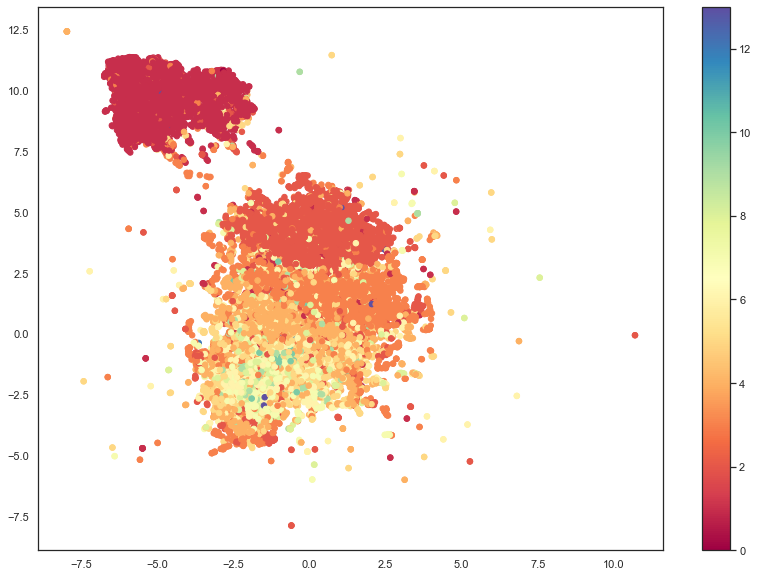

In [29]:
sns.set(context='notebook', style='white', rc={'figure.figsize':(14,10)})

col = []
for item in np.array(y_train):
    col.append(item)
    
sc = plt.scatter(embedding[:, 0], embedding[:, 1], c = col,  cmap='Spectral', s=30)
plt.colorbar(sc)
plt.show()

#### Embedding move_data using UMAP

In [15]:
reducer2 = UMAP(n_neighbors = 15, min_dist = 0.1, n_components = 15 )
reducer2.fit(X_train,y_train)
umap_features = reducer2.transform(X) 
umap_features.shape

(29181, 15)

In [16]:
pd2 = pd.DataFrame(umap_2d_features)
pd2.to_csv("umap_features_2_dim")
pd_15 = pd.DataFrame(umap_features)
pd_15.to_csv("umap_features_15_dim")